In [1]:
import os 
import matplotlib.pyplot as plt
os.chdir('/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py')
from epigraphhub.data.get_data import get_cluster_data, get_georegion_data
#from epigraphhub.analysis.clustering import compute_clusters
from epigraphhub.models.ngboost_models import *
#from ngboost.learners import default_tree_learner
os.chdir('/Users/eduardoaraujo/Desktop')

In [2]:
%%time 

target_curve_name = 'hosp'
predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d']
ini_date = '2020-04-01'

train_all_cantons(target_curve_name,
                 predictors,
                 ini_date = ini_date)

CPU times: user 4min 59s, sys: 1.97 s, total: 5min 1s
Wall time: 10min 58s


In [2]:
def eval_all_cantons(
    target_curve_name,
    predictors,
    vaccine=True,
    smooth=True,
    ini_date="2020-04-01",
    path = 'saved_models'
):

    """
    Function to make prediction for all the cantons

    Important:
    * By default the function is using the clustering cantons and the data since 2020
    * For the predictor hospCapacity is used as predictor the column ICU_Covid19Patients

    :params target_curve_name: string to indicate the target column of the predictions
    :params predictors: variables that  will be used in model
    :params vaccine: It determines if the vaccine data from owid will be used or not
    :params smooth: It determines if data will be smoothed or not
    :params ini_date: Determines the beggining of the train dataset
    :params split: float. Determines which percentage of the data will be used to train the model
    :params parameters_model: dict with the params that will be used in the ngboost
                             regressor model.

    returns: Dataframe.
    """

    df_all = pd.DataFrame()

    all_cantons = ['LU', 'JU', 'AR', 'VD', 'NE', 'FR', 'GL', 'GR', 'SG', 'AI', 'NW',
       'ZG', 'SH', 'GE', 'BL', 'BE', 'BS', 'TI', 'UR', 'AG',
       'TG', 'SZ', 'SO', 'ZH', 'VS', 'OW']

    for canton in all_cantons:

        df = get_cluster_data(
            "switzerland", predictors, [canton], vaccine=vaccine, smooth=smooth
        )

        df = df.fillna(0)



        target_name = f"{target_curve_name}_{canton}"
        horizon = 14
        maxlag = 14

        df_pred = rolling_predictions_load_model(
                target_name,
                df,
                ini_date=ini_date,
                horizon_forecast=horizon,
                maxlag=maxlag,
                path = path
            )

        df_all = pd.concat([df_all, df_pred])

    return df_all

In [5]:
def rolling_predictions_load_model(
    target_name,
    data,
    ini_date="2020-03-01",
    horizon_forecast=14,
    maxlag=14,
    path = 'saved_models/', 
):

    """
    Function to apply a ngboost regressor model given a dataset and a target column.
    This function will train multiple models, each one specilist in predict the X + n
    days, of the target column, where n is in the range (1, number of days that you
                                                         want predict).
    This function split the data in train and test dataset and returns the predictions
    made using the test dataset.
    Important:

    params target_name:string. Name of the target column.
    params data: dataframe. Dataframe with features and target column.
    params ini_date: string. Determines the beggining of the train dataset
    params split: float. Determines which percentage of the data will be used to train the model
    params horizon_forecast: int. Number of days that will be predicted
    params max_lag: int. Number of the last days that will be used to forecast the next days
    params parameters_model: dict with the params that will be used in the ngboost
                             regressor model.

    returns: DataFrame.
    """

    target = data[target_name]

    df_lag = build_lagged_features(copy.deepcopy(data), maxlag=maxlag)

    ini_date = max(
        df_lag.index[0], target.index[0], datetime.strptime(ini_date, "%Y-%m-%d")
    )

    df_lag = df_lag[ini_date:]
    target = target[ini_date:]
    target = target.dropna()
    df_lag = df_lag.dropna()

    # remove the target column and columns related with the day that we want to predict
    df_lag = df_lag.drop(data.columns, axis=1)

    targets = {}

    for T in np.arange(1, horizon_forecast + 1, 1):
        targets[T] = target.shift(-(T))[: -(T)]

    if np.sum(target) > 0.0:

        idx = pd.period_range(
            start=df_lag.index[0], end=df_lag.index[-1], freq=f"{horizon_forecast}D"
        )

        idx = idx.to_timestamp()

        preds5 = np.empty((len(idx), horizon_forecast))
        preds50 = np.empty((len(idx), horizon_forecast))
        preds95 = np.empty((len(idx), horizon_forecast))

        for T in range(1, horizon_forecast + 1):

        
            model = load(f"{path}/ngboost_{target_name}_{T}D.joblib")

            pred = model.pred_dist(df_lag.loc[idx])

            pred50 = pred.median()

            pred5, pred95 = pred.interval(alpha=0.95)

            preds5[:, (T - 1)] = pred5
            preds50[:, (T - 1)] = pred50
            preds95[:, (T - 1)] = pred95

        #train_size = len(X_train)

        y5 = preds5.flatten()
        y50 = preds50.flatten()
        y95 = preds95.flatten()

        x = pd.period_range(
            start=df_lag.index[1], end=df_lag.index[-1], freq="D"
        ).to_timestamp()

        x = np.array(x)

        y5 = np.array(y5)

        y50 = np.array(y50)

        y95 = np.array(y95)

        target = targets[1]

        dif = len(x) - len(y5)

        if dif < 0:
            y5 = y5[: len(y5) + dif]
            y50 = y50[: len(y50) + dif]
            y95 = y95[: len(y95) + dif]

        df_pred = pd.DataFrame()
        df_pred["target"] = target
        df_pred["date"] = x
        df_pred["lower"] = y5
        df_pred["median"] = y50
        df_pred["upper"] = y95
        #df_pred["train_size"] = [train_size] * len(df_pred)
        df_pred["canton"] = [target_name[-2:]] * len(df_pred)

    else:
        target = targets[1]
        x = pd.period_range(
            start=df_lag.index[1], end=df_lag.index[-1], freq="D"
        ).to_timestamp()

        x = np.array(x)

        df_pred = pd.DataFrame()
        df_pred["target"] = target
        df_pred["date"] = x
        df_pred["lower"] = [0.0] * len(df_pred)
        df_pred["median"] = [0.0] * len(df_pred)
        df_pred["upper"] = [0.0] * len(df_pred)
        #df_pred["train_size"] = [len(X_train)] * len(df_pred)
        df_pred["canton"] = [target_name[-2:]] * len(df_pred)

    return df_pred


In [6]:
%%time

target_curve_name = 'icu_patients'
predictors = ['foph_test_d', 'foph_cases_d', 'foph_hosp_d', 'foph_hospcapacity_d']
ini_date = '2020-04-01'

df_val_hosp  = eval_all_cantons(
     target_curve_name,
    predictors, 
    vaccine=True,
    smooth=True,
    ini_date=ini_date,
    path = 'saved_models' 
)

CPU times: user 23.4 s, sys: 2.18 s, total: 25.6 s
Wall time: 6min 42s


In [10]:
df_val_hosp.to_csv('val_icu_swiss.csv')

In [11]:
df_val_hosp

,target,date,lower,median,upper,canton
2020-04-01,7.714286,2020-04-02,6.340338,7.730874,9.426376,LU
2020-04-02,10.857143,2020-04-03,9.599143,11.624282,14.076667,LU
2020-04-03,13.214286,2020-04-04,11.856599,14.219417,17.053105,LU
2020-04-04,16.142857,2020-04-05,14.506180,17.740003,21.694733,LU
2020-04-05,18.428571,2020-04-06,15.856677,21.948262,30.380024,LU
...,...,...,...,...,...,...
2022-03-20,7.857143,2022-03-21,3.303131,6.090216,11.228961,OW
2022-03-21,6.857143,2022-03-22,2.934837,5.473890,10.209586,OW
2022-03-22,5.857143,2022-03-23,2.731950,5.318847,10.355288,OW
2022-03-23,5.000000,2022-03-24,2.411276,5.066096,10.643879,OW


In [12]:
def make_plots(df,canton, title):
    
    df = df.loc[df.canton == canton]
    
    fig, ax = plt.subplots(dpi = 150)

    ax.plot(df.target, label = 'Data')
    ax.plot(df['median'], label = 'Predict', color = 'tab:orange')
    ax.fill_between(df.index, df.lower, df.upper, color = 'tab:orange', alpha = 0.5),

    #ax.axvline(df.index[df.train_size[0]], 0, max(df[['target', 'lower', 'median', 'upper']].max()), label = 'Train/Test', color = 'green', ls = '--')
    
    ax.legend()
    ax.grid()
    ax.set_title(title)

    for label in ax.get_xticklabels():
        label.set_rotation(30)
        
    plt.show()
    

    return
    

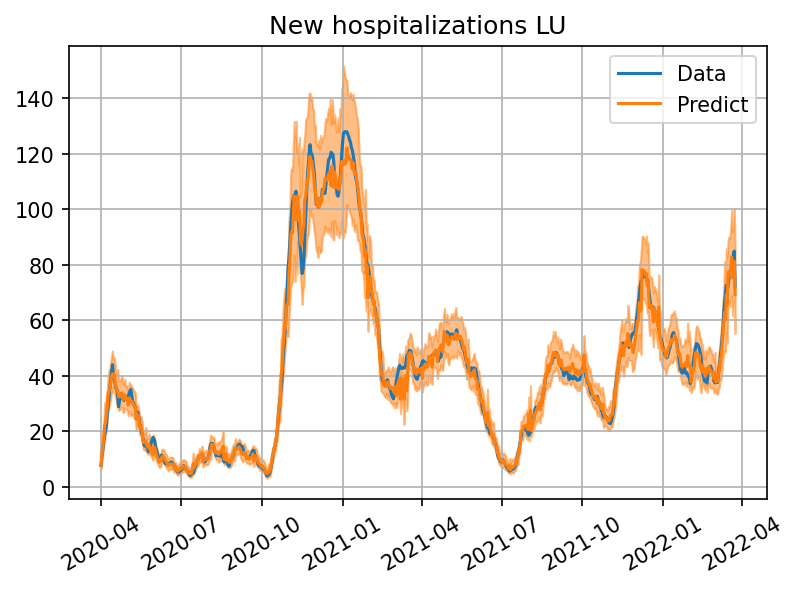

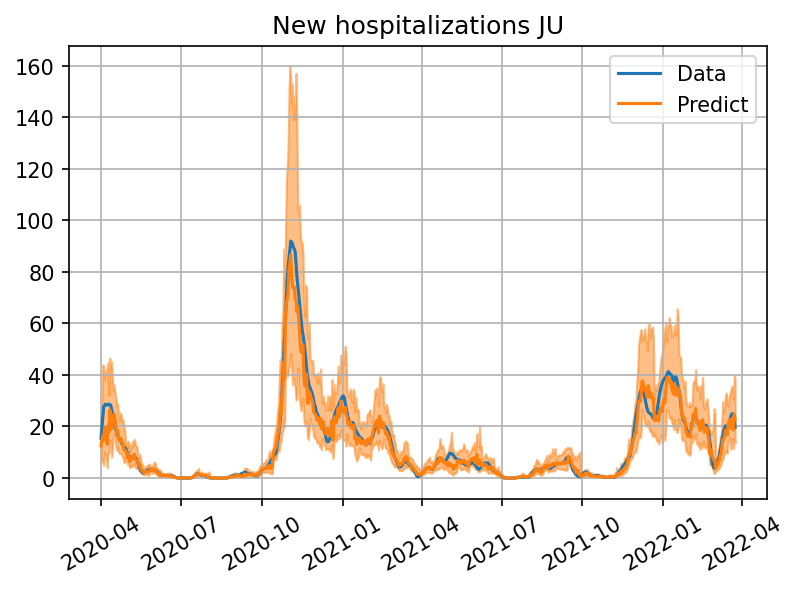

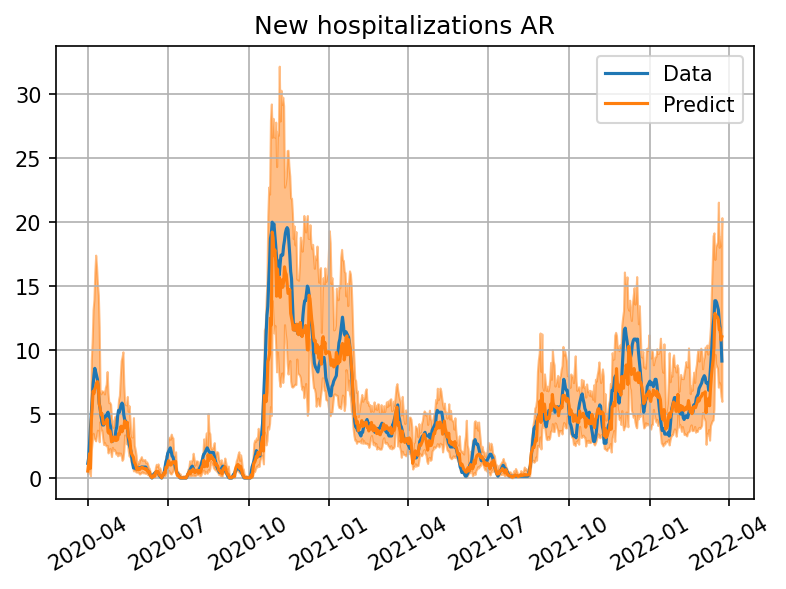

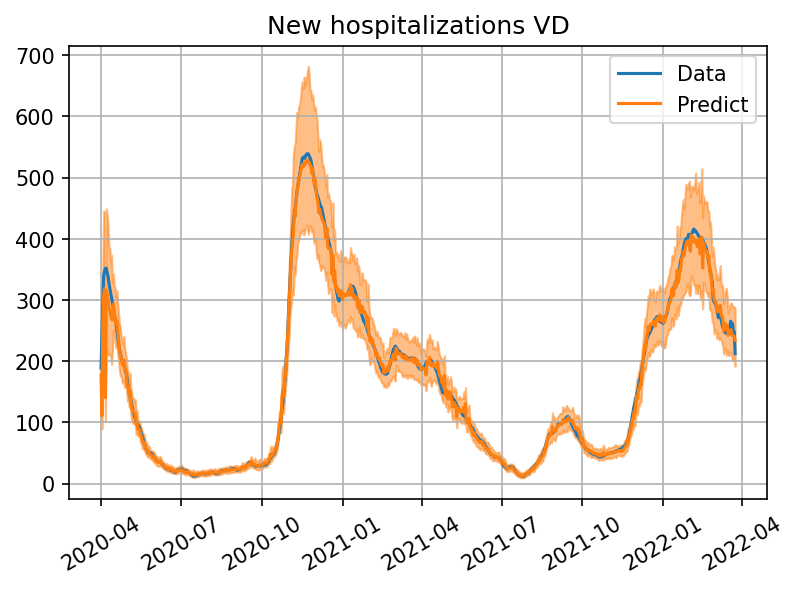

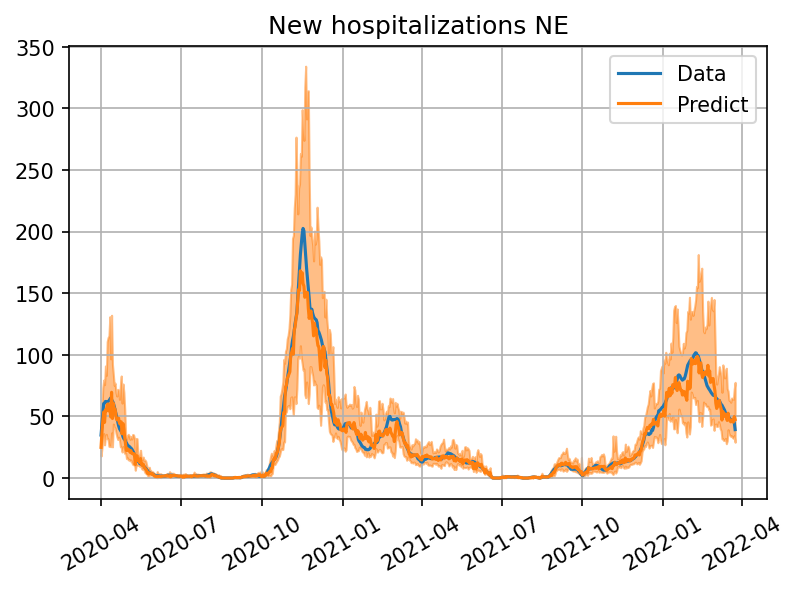

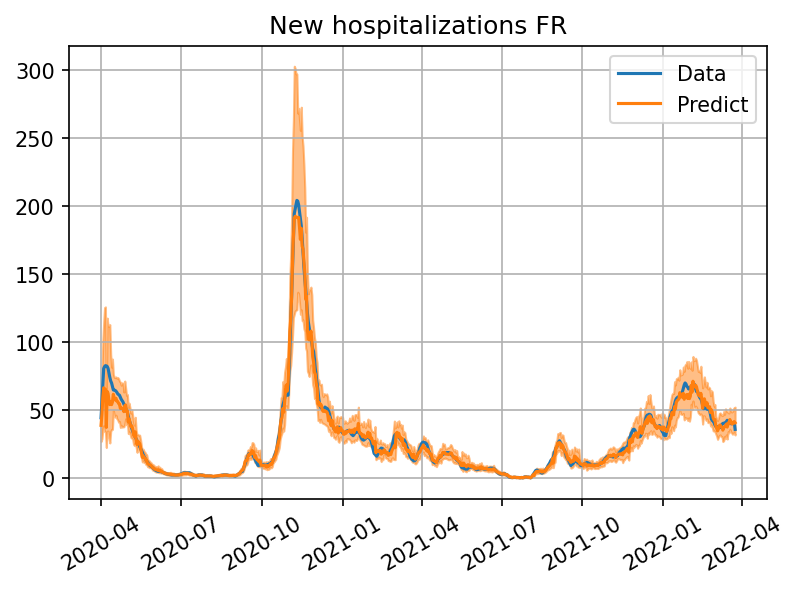

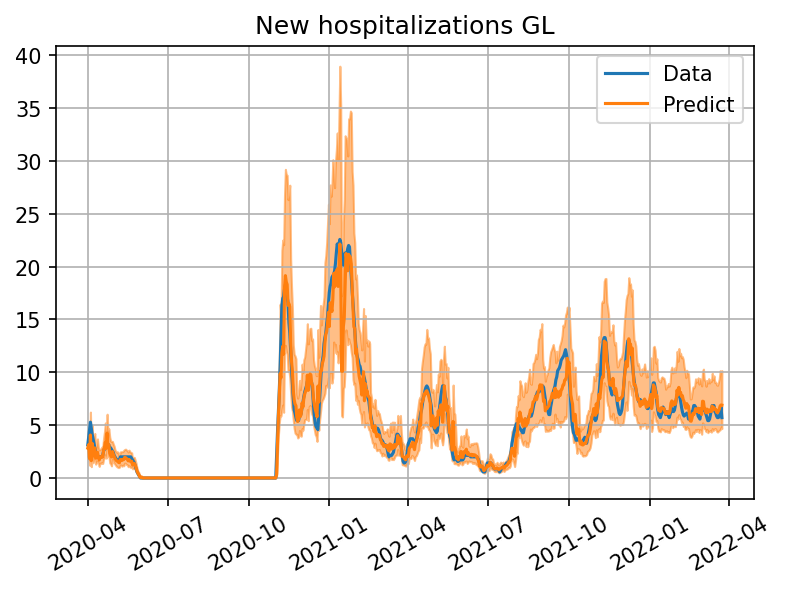

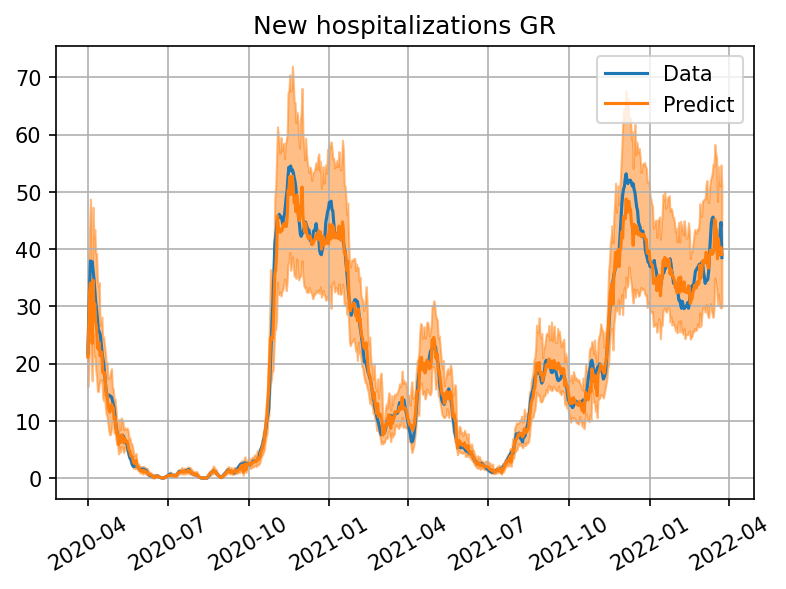

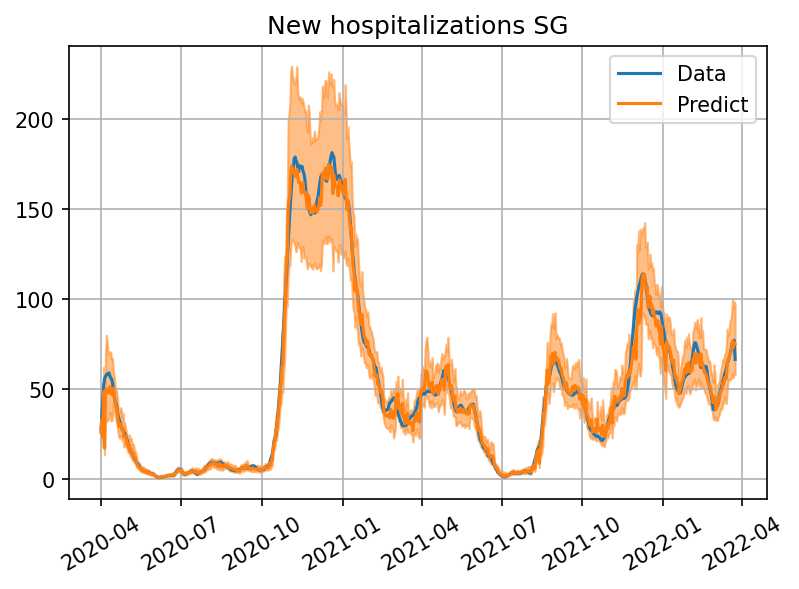

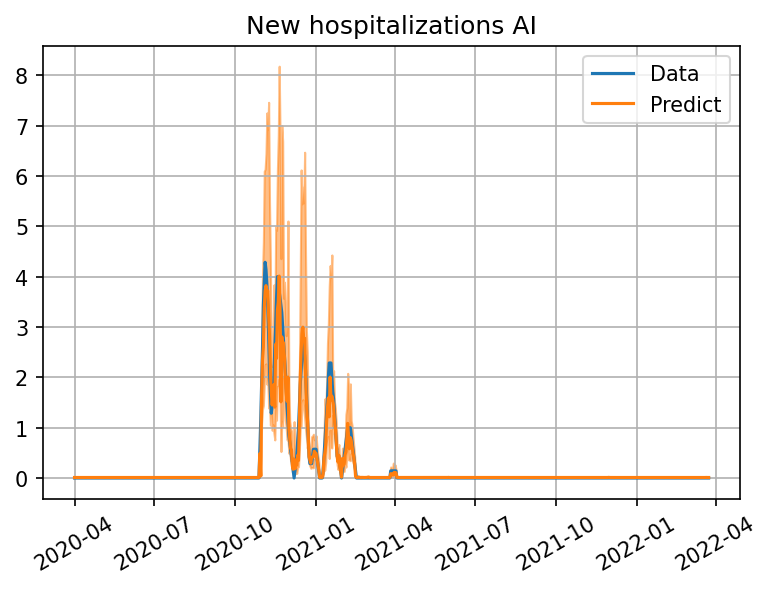

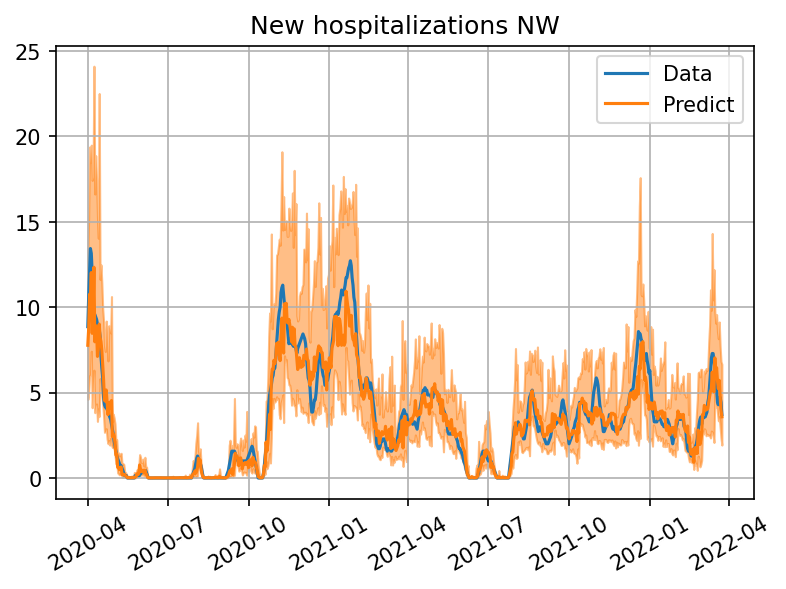

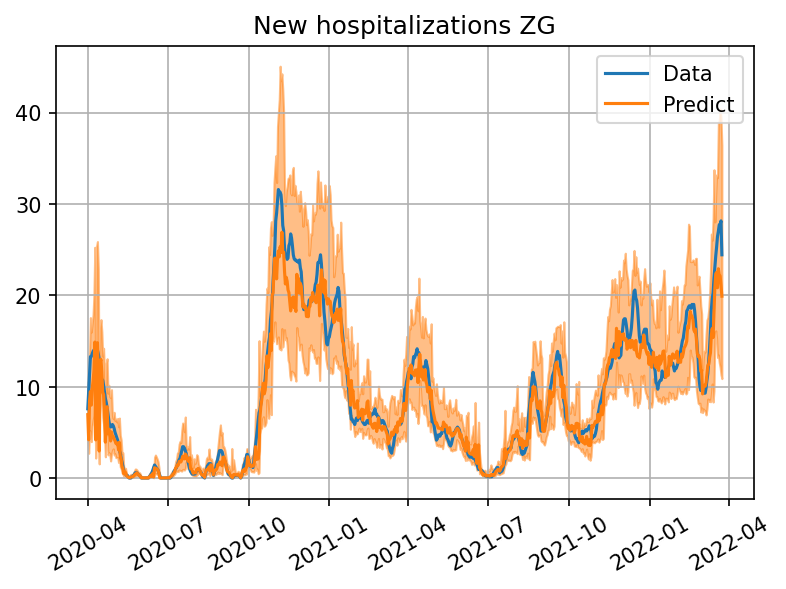

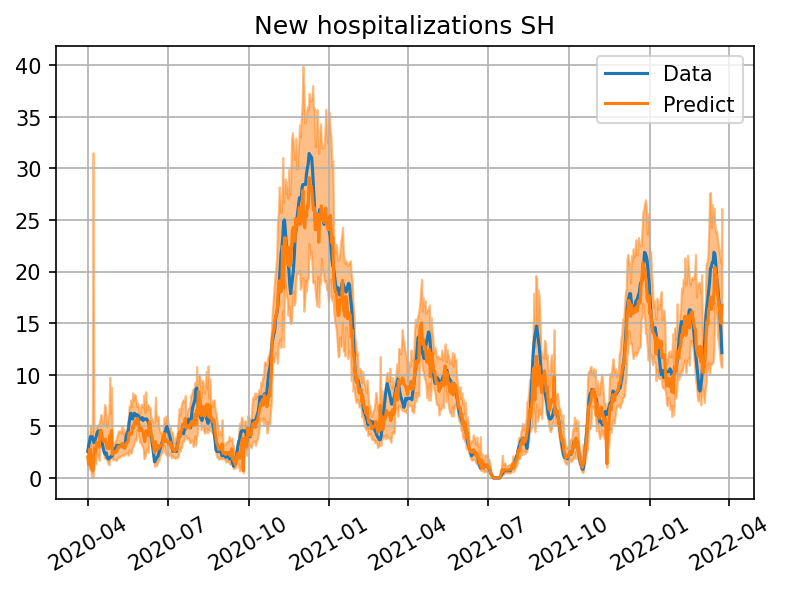

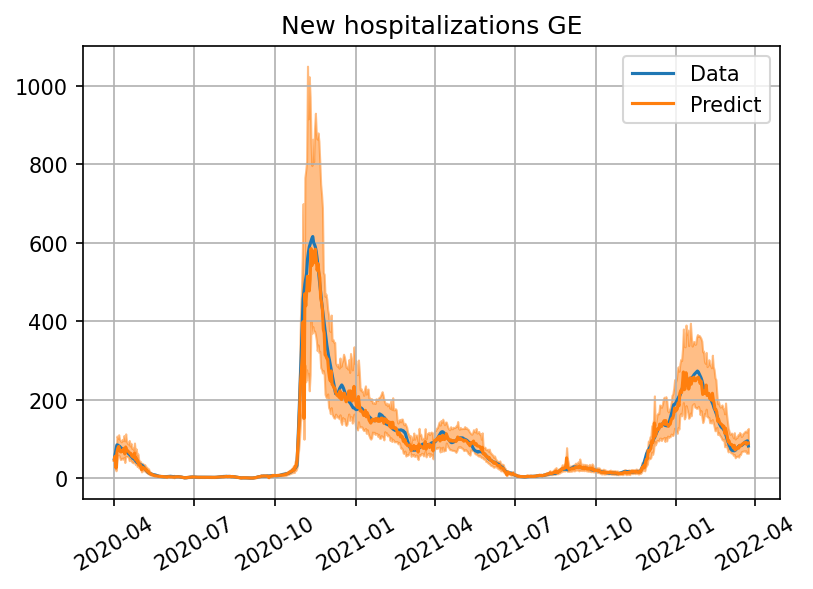

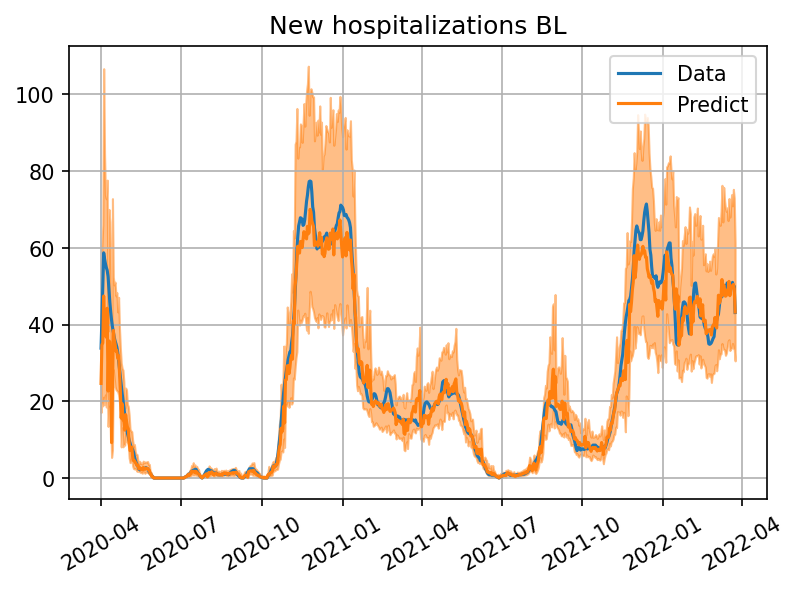

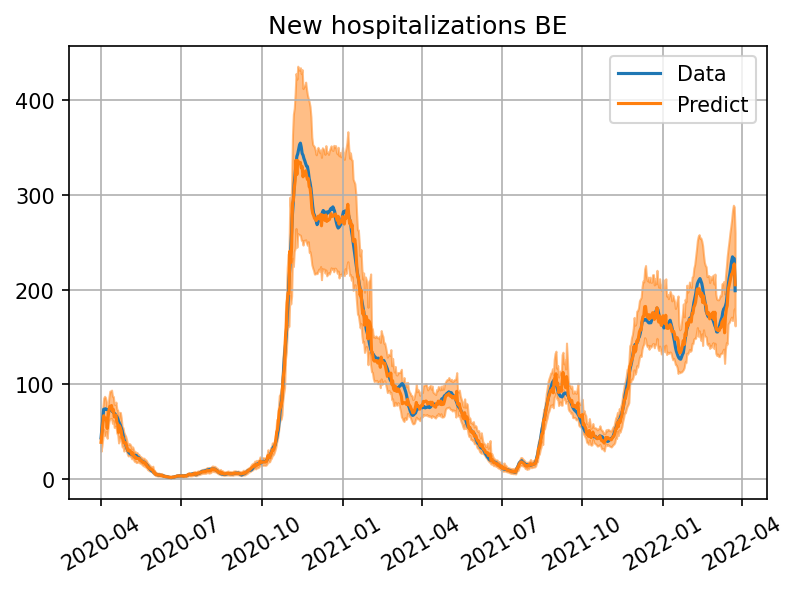

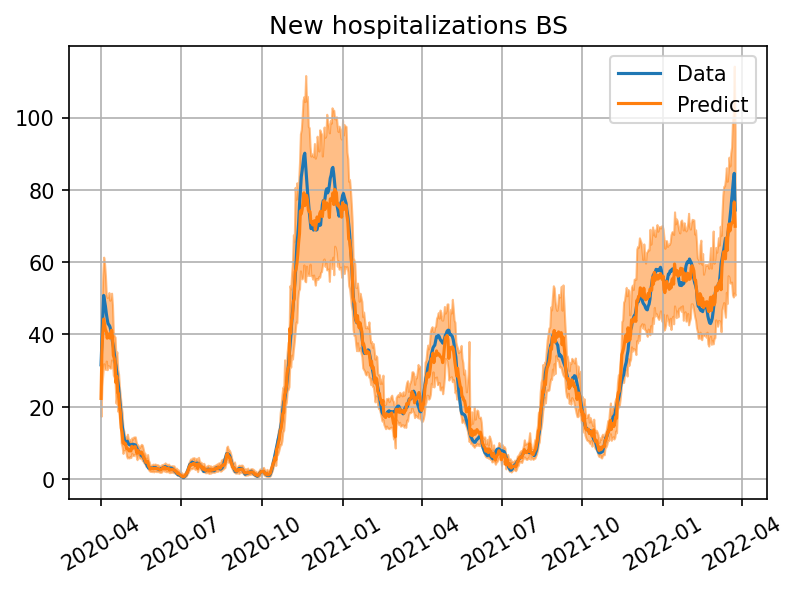

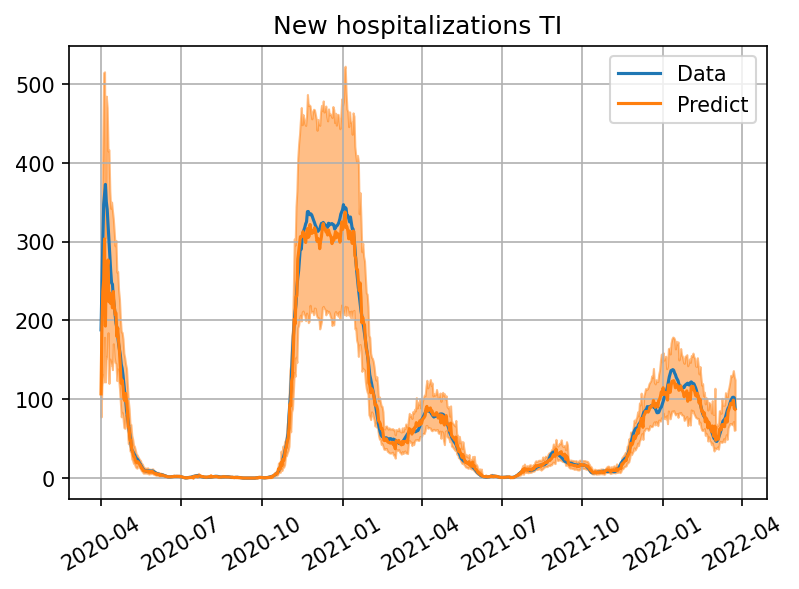

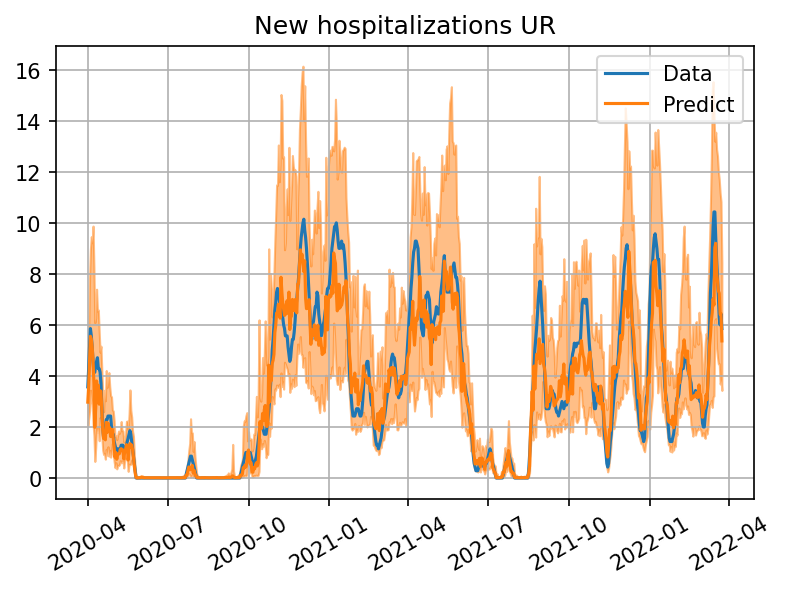

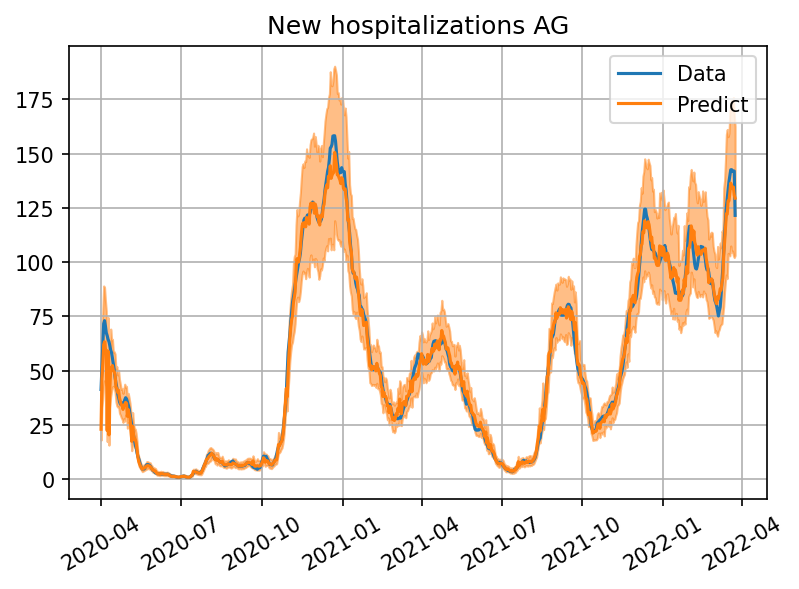

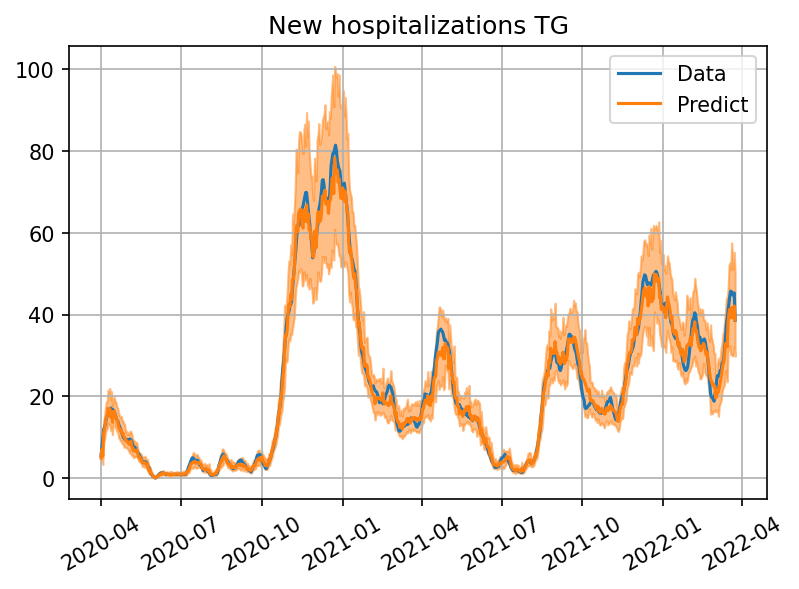

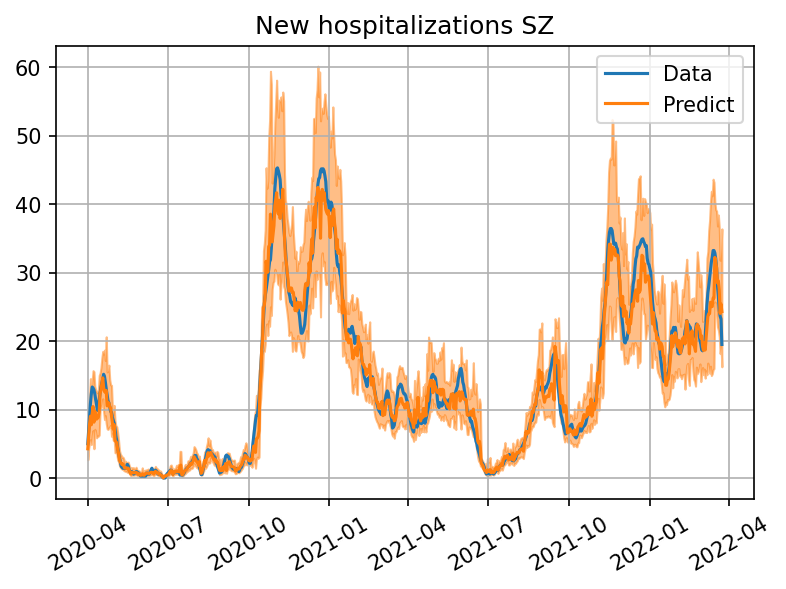

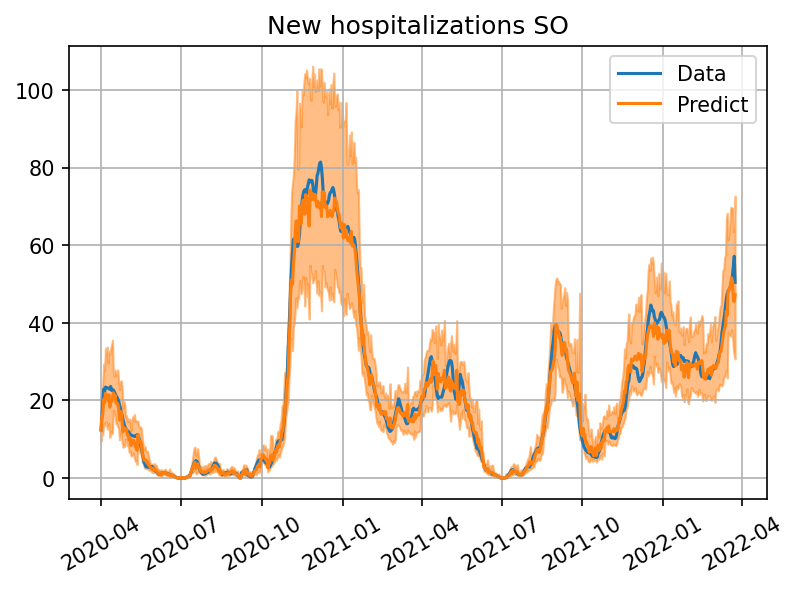

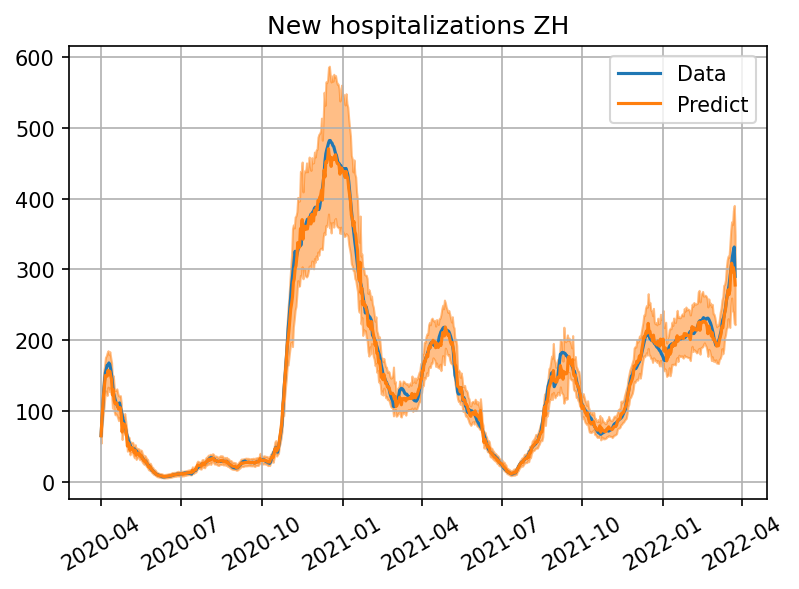

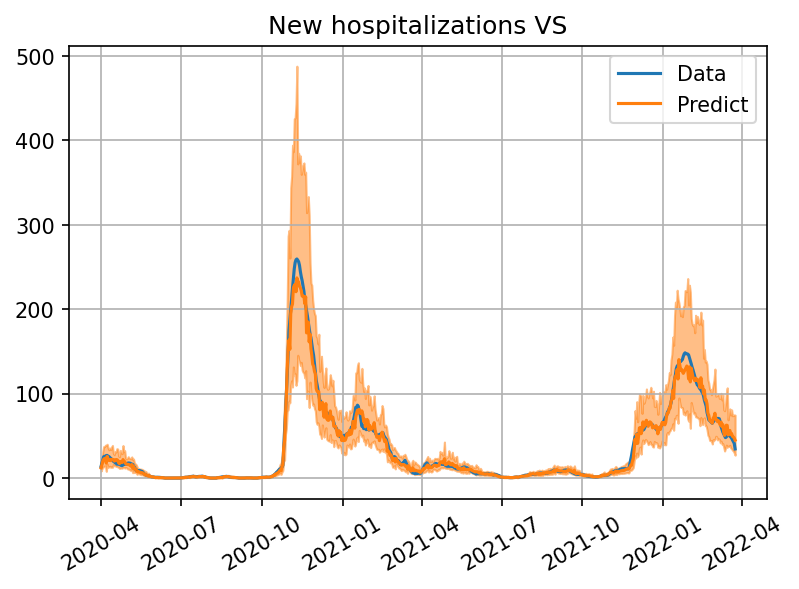

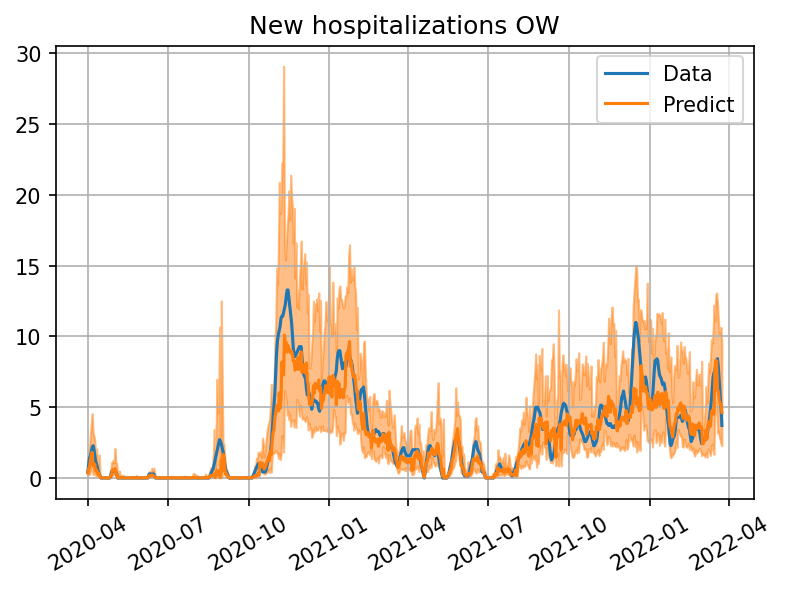

In [13]:

for canton in df_val_hosp.canton.unique():
    make_plots(df_val_hosp, canton, f'New hospitalizations {canton}')